<a href="https://colab.research.google.com/github/psheetalreddy/XAI-Based-Retinal-Disease-Classification-using-Fine-Tuned-ResNet50-with-Grad-CAM/blob/main/1_Model_Development_ResNet50_FineTuning_GradCAM_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import seaborn as sns

In [ ]:
!pip install --upgrade tensorflow opencv-python matplotlib numpy

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_INITIAL = 10
EPOCHS_FINE = 15

test_dir = "/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset/test_dir"
val_dir = "/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset/valid_dir"
train_dir = "/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset/train_dir"

In [5]:
import os
print(os.listdir("/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset"))
print(os.listdir(test_dir))
print(os.listdir(val_dir))
print(os.listdir(train_dir))


['cat_to_name.json', 'train_dir', 'valid_dir', 'test_dir']
['3', '2', '4', '1']
['4', '2', '1', '3']
['3', '4', '1', '2']


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2702 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 674 images belonging to 4 classes.


In [7]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Stage 1

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
def make_prediction(img_arry, model):
  pred = model.predict(img_array)
  predicted_class = np.argmax(pred)

  print("Predicted class:", predicted_class + 1)
  print("Prediction probabilities:", pred)

#-----------------------------------------------------------------

def evaluate_results(test_gen, model):
  loss, acc = model.evaluate(test_gen)
  print("Test Accuracy:", acc)

  preds = model.predict(test_gen)
  y_pred = np.argmax(preds, axis=1)
  y_true = test_gen.classes

  print(classification_report(y_true, y_pred))

  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt="d")
  plt.show()

#------------------------------------------------------------------

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
  grad_model = tf.keras.models.Model(
      [model.inputs],
      [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(img_array)
      class_index = tf.argmax(predictions[0])
      loss = predictions[:, class_index]

  grads = tape.gradient(loss, conv_outputs)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  conv_outputs = conv_outputs[0]

  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

#--------------------------------------------------------------------

def overlay_heatmap(img_path, heatmap, alpha=0.4):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

  heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

  plt.figure(figsize=(6,6))
  plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

#Phase 1 - model training

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2),
    ModelCheckpoint("/content/drive/MyDrive/Projects/Mini-project/best_model.h5", save_best_only=True)
]

In [10]:
history_initial = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_INITIAL,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5161 - loss: 1.3082

169/169 ━━━━━━━━━━━━━━━━━━━━ 1042s 6s/step - accuracy: 0.5169 - loss: 1.3061 - val_accuracy: 0.7967 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7659 - loss: 0.6873

169/169 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.7660 - loss: 0.6869 - val_accuracy: 0.8335 - val_loss: 0.4445 - learning_rate: 1.0000e-04
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8079 - loss: 0.5269

169/169 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.8079 - loss: 0.5269 - val_accuracy: 0.8549 - val_loss: 0.4304 - learning_rate: 1.0000e-04
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8263 - loss: 0.4549

169/169 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.8263 - loss: 0.4549 - val_accuracy: 0.8585 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8515 - loss: 0.3953

169/169 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.8515 - loss: 0.3954 - val_accuracy: 0.8704 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 602s 4s/step - accuracy: 0.8527 - loss: 0.3670 - val_accuracy: 0.8728 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 599s 4s/step - accuracy: 0.8563 - loss: 0.3696 - val_accuracy: 0.8644 - val_loss: 0.3974 - learning_rate: 1.0000e-04
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8611 - loss: 0.3362

169/169 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.8612 - loss: 0.3362 - val_accuracy: 0.8740 - val_loss: 0.3880 - learning_rate: 1.0000e-04
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8782 - loss: 0.3298

169/169 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.8782 - loss: 0.3298 - val_accuracy: 0.8799 - val_loss: 0.3758 - learning_rate: 1.0000e-04
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8840 - loss: 0.3032

169/169 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.8840 - loss: 0.3032 - val_accuracy: 0.8787 - val_loss: 0.3568 - learning_rate: 1.0000e-04


In [13]:
model.evaluate(test_gen)

43/43 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.8897 - loss: 0.3769


[0.32574597001075745, 0.8931750655174255]

43/43 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       166
           1       0.96      0.93      0.95       175
           2       0.89      0.76      0.82       161
           3       0.78      0.94      0.85       172

    accuracy                           0.89       674
   macro avg       0.89      0.89      0.89       674
weighted avg       0.89      0.89      0.89       674



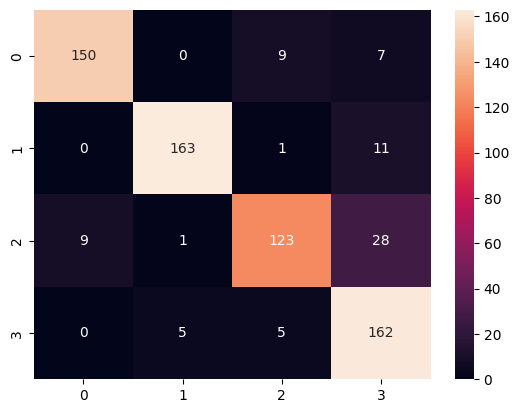

In [35]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


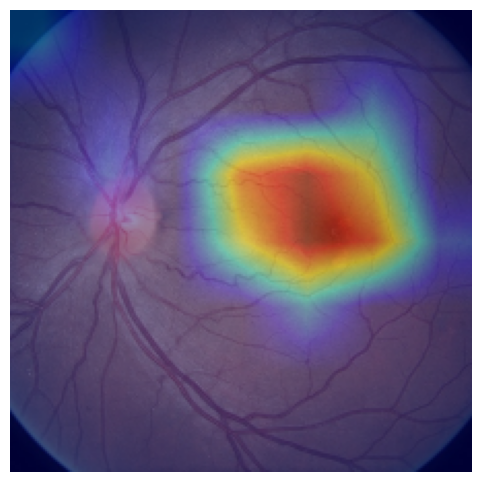

In [33]:
img_path = "/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset/test_dir/2/10009_right.jpeg"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")
overlay_heatmap(img_path, heatmap)

In [34]:
pred = model.predict(img_array)
predicted_class = np.argmax(pred)

print("Predicted class:", predicted_class + 1)
print("Prediction probabilities:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: 2
Prediction probabilities: [[1.5835558e-09 9.4730729e-01 4.4229811e-10 5.2692641e-02]]


In [ ]:
model_path = "/content/drive/MyDrive/Projects/Mini-project/phase1_best.keras"
model.save(model_path)

#Phase 2 - fine tuning

In [24]:
from tensorflow.keras.models import load_model

phase1_path = "/content/drive/MyDrive/Projects/Mini-project/phase1_best.keras"
model = load_model(phase1_path)

print("Phase 1 model loaded successfully")

Phase 1 model loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

phase2_checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Projects/Mini-project/phase2_best.keras",
    save_best_only=True
)

callbacks_phase2 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2),
    phase2_checkpoint
]

In [37]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_phase2
)

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - accuracy: 0.8702 - loss: 0.3614 - val_accuracy: 0.8835 - val_loss: 0.3767 - learning_rate: 1.0000e-05
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 724s 4s/step - accuracy: 0.8689 - loss: 0.3229 - val_accuracy: 0.8799 - val_loss: 0.3733 - learning_rate: 1.0000e-05
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.8780 - loss: 0.3248 - val_accuracy: 0.8930 - val_loss: 0.3513 - learning_rate: 1.0000e-05
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.8866 - loss: 0.3056 - val_accuracy: 0.8906 - val_loss: 0.3661 - learning_rate: 1.0000e-05
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.8908 - loss: 0.2767 - val_accuracy: 0.8894 - val_loss: 0.3557 - learning_rate: 1.0000e-05
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step - accuracy: 0.9112 - loss: 0.2206 - val_accuracy: 0.8906 - val_loss: 0.3427 - learning_rate: 1.0000e-05
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step - acc

In [40]:
model_finetuned_path = "/content/drive/MyDrive/Projects/Mini-project/phase2_best.keras"
model_finetuned = load_model(model_finetuned_path)

43/43 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8932 - loss: 0.3638
Test Accuracy: 0.8961424231529236
43/43 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       166
           1       0.98      0.95      0.96       175
           2       0.88      0.79      0.83       161
           3       0.80      0.93      0.86       172

    accuracy                           0.90       674
   macro avg       0.90      0.89      0.90       674
weighted avg       0.90      0.90      0.90       674



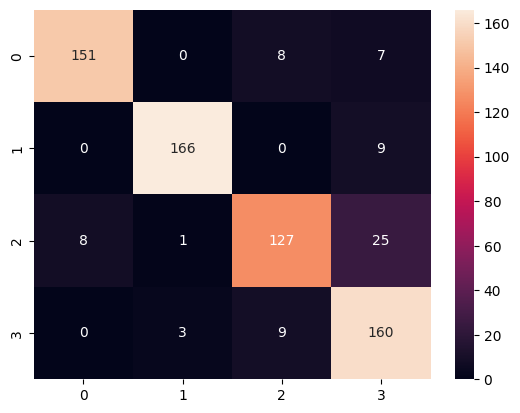

In [41]:
evaluate_results(test_gen, model_finetuned)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: 4
Prediction probabilities: [[5.1693962e-04 4.0123457e-04 2.2514830e-03 9.9683028e-01]]


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


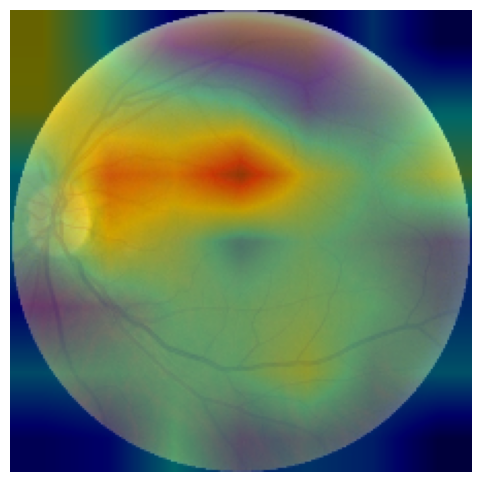

In [42]:
img_path = "/content/drive/MyDrive/Projects/Mini-project/eye-disease-dataset/test_dir/4/2523_left.jpg"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

make_prediction(img_array, model_finetuned)
heatmap = make_gradcam_heatmap(img_array, model_finetuned, "conv5_block3_out")
overlay_heatmap(img_path, heatmap)